In [1]:
library("ggplot2")
library("STRbook")
library("expm")
library("Matrix")

Loading required package: Matrix


Attaching package: 'expm'


The following object is masked from 'package:Matrix':

    expm




In [2]:
data("SSTlandmask", package = "STRbook")
data("SSTlonlat", package = "STRbook")
data("SSTdata", package = "STRbook")
delete_rows <- which(SSTlandmask == 1)   # remove land values
SST_Oct97 <- SSTdata[-delete_rows, 334]  # save Oct 1997 SSTs
SSTdata <- SSTdata[-delete_rows, 1:328]  # until April 1997
SSTlonlat$mask <- SSTlandmask            # assign mask to df

In [3]:
Z <- t(SSTdata)                         # data matrix
spat_mean <- apply(SSTdata, 1, mean)    # spatial mean
nT <- ncol(SSTdata)                     # no. of time points
Zspat_detrend <- Z - outer(rep(1, nT),  # detrend data
                           spat_mean)
Zt <- 1/sqrt(nT-1)*Zspat_detrend        # normalize
E <- svd(Zt)                            # SVD

In [4]:
n <- 10


In [5]:
options(digits = 3)

In [6]:
TS <- Zspat_detrend %*% E$v[, 1:n]
summary(colMeans(TS))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-3.36e-16 -8.60e-17  3.06e-16  2.08e-16  3.84e-16  8.95e-16 

In [7]:
tau <- 6
nT <- nrow(TS)
TStplustau <- TS[-(1:tau), ] # TS with first tau time pts removed
TSt <- TS[-((nT-5):nT), ]

In [8]:
Cov0 <- crossprod(TS)/nT
Covtau <- crossprod(TStplustau,TSt)/(nT - tau)

In [9]:
C0inv <- solve(Cov0)
Mest <- Covtau %*% C0inv
Ceta <- Cov0 - Covtau %*% C0inv %*% t(Covtau)

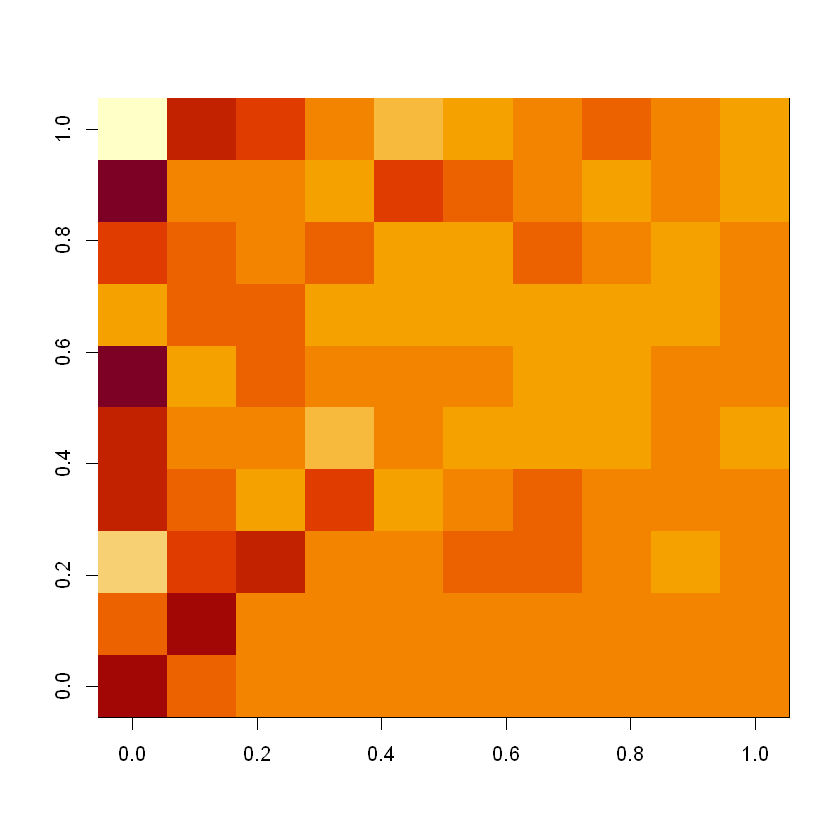

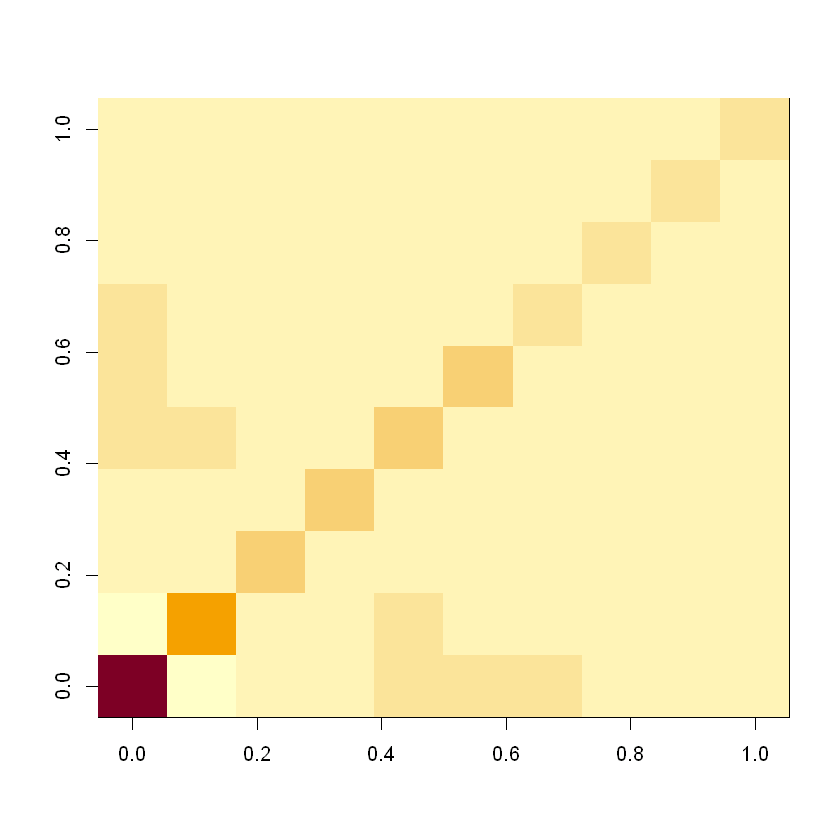

In [10]:
image(Mest)
image(Ceta)

In [11]:
SSTlonlat$pred <- NA
alpha_forecast <- Mest %*% TS[328, ]

In [12]:
idx <- which(SSTlonlat$mask == 0)
SSTlonlat$curr[idx]  <- as.numeric(E$v[, 1:n] %*% TS[328, ] +
                                       spat_mean)
SSTlonlat$pred[idx]  <- as.numeric(E$v[, 1:n] %*% alpha_forecast +
                                       spat_mean)

In [13]:
SSTlonlat$obs1[idx]  <- SSTdata[, 328]
SSTlonlat$obs2[idx]  <- SST_Oct97

In [14]:
C <- Mest %*% Cov0 %*% t(Mest) + Ceta

In [15]:
SSTlonlat$predse[idx] <-
    sqrt(diag(E$v[, 1:n] %*% C %*% t(E$v[, 1:n])))

In [16]:
g1 <- ggplot(SSTlonlat) +
    geom_tile(aes(lon,lat,fill=curr)) +
    scale_fill_distiller(palette = "Spectral", limits = c(-2,2), name = "degC") +
    theme_bw() + coord_fixed()

g2 <- ggplot(SSTlonlat) +
    geom_tile(aes(lon,lat,fill=pred)) +
    scale_fill_distiller(palette = "Spectral", limits = c(-1.2,1.2), name = "degC") +
    theme_bw() + coord_fixed()


g3 <- ggplot(SSTlonlat) +
        geom_tile(aes(lon,lat,fill=obs1)) +
    scale_fill_distiller(palette = "Spectral", limits = c(-2,2), name = "degC") +
    theme_bw() + coord_fixed()

g4 <- ggplot(SSTlonlat) +
    geom_tile(aes(lon,lat,fill=obs2)) +
    scale_fill_distiller(palette = "Spectral",name = "degC") +
    theme_bw() + coord_fixed()


g5 <- ggplot(SSTlonlat) +
    geom_tile(aes(lon,lat,fill=predse)) +
    scale_fill_distiller(palette = "Spectral",name = "degC") +
    theme_bw() + coord_fixed()

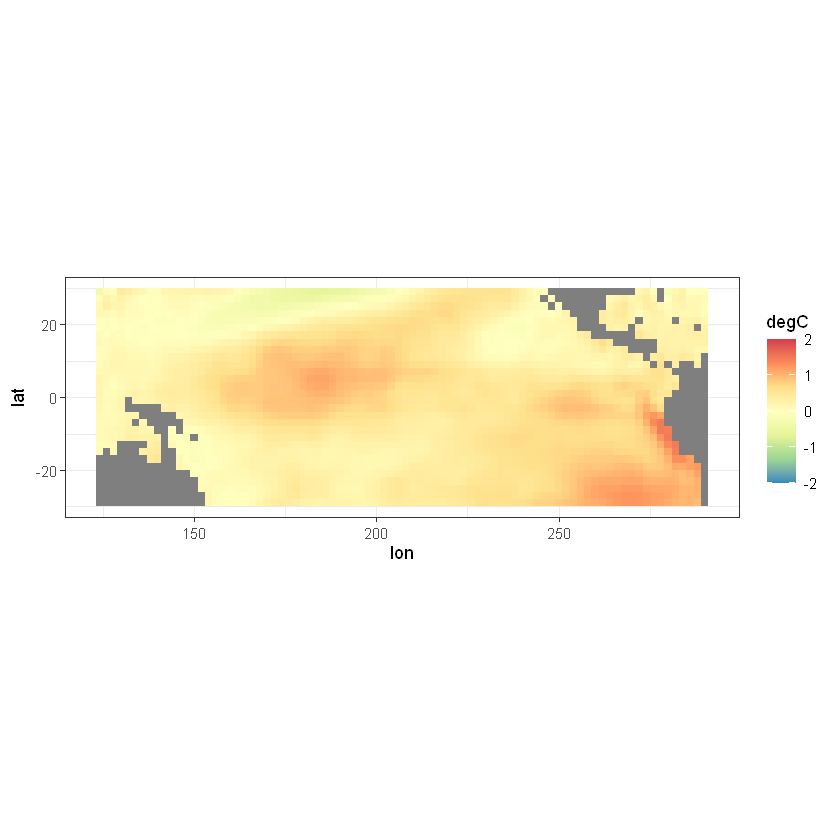

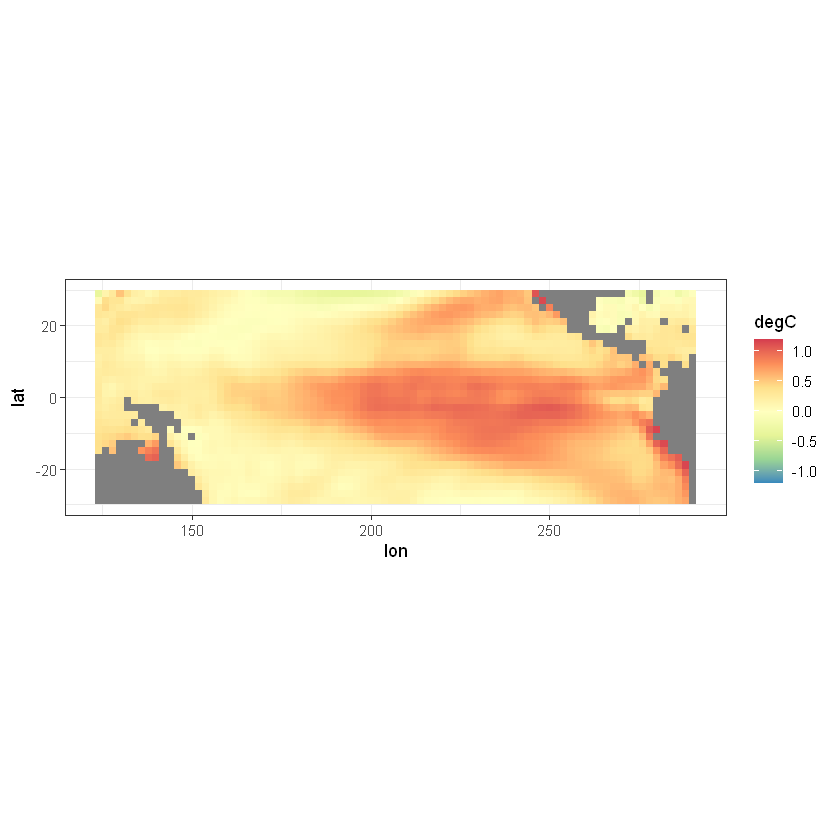

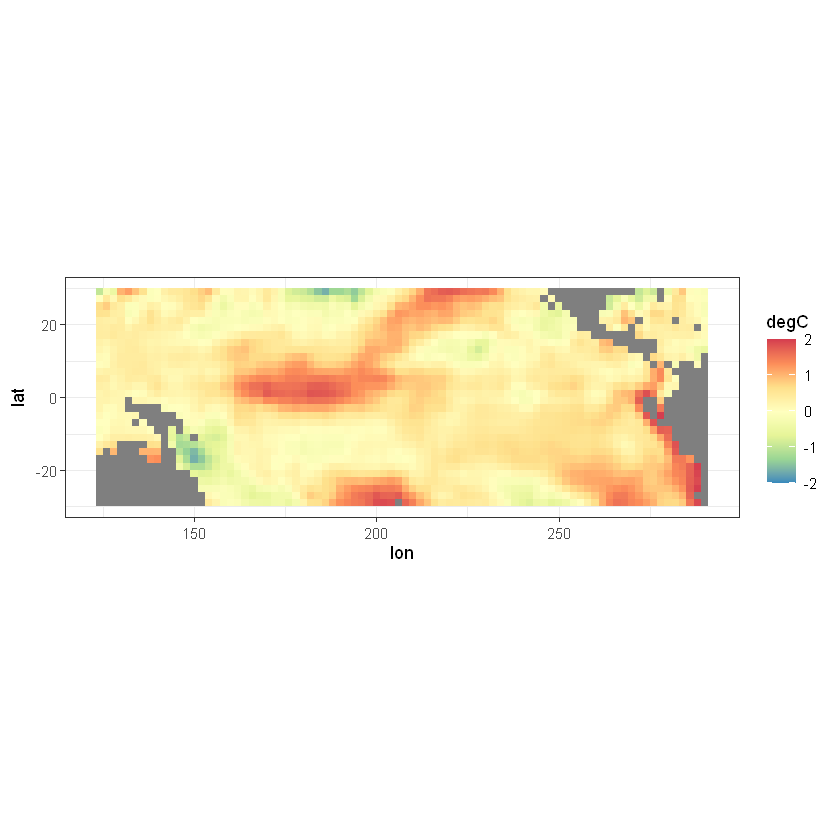

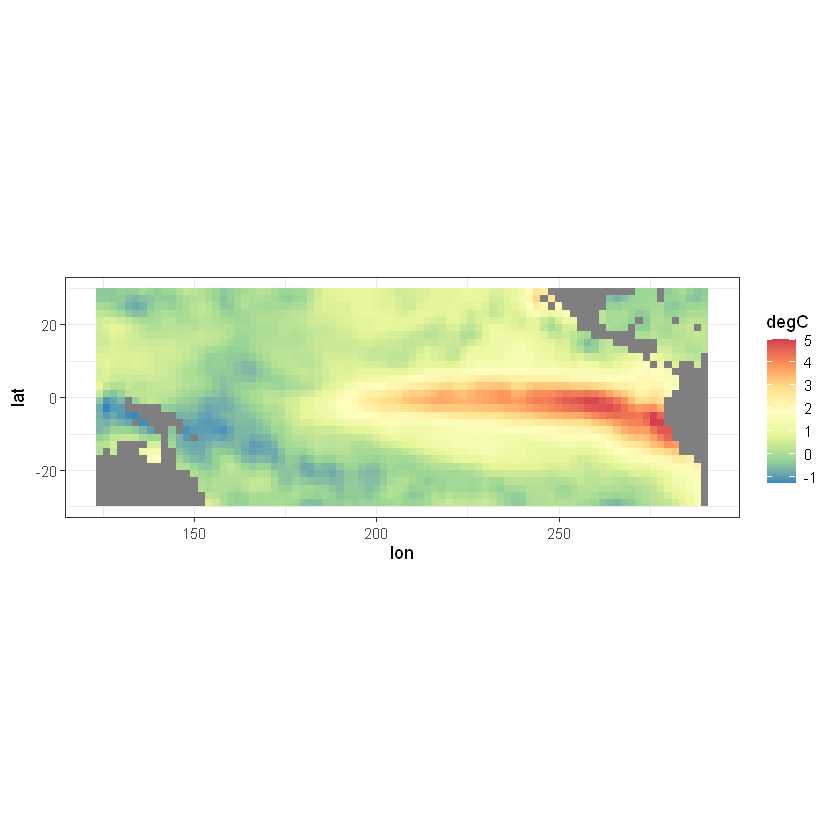

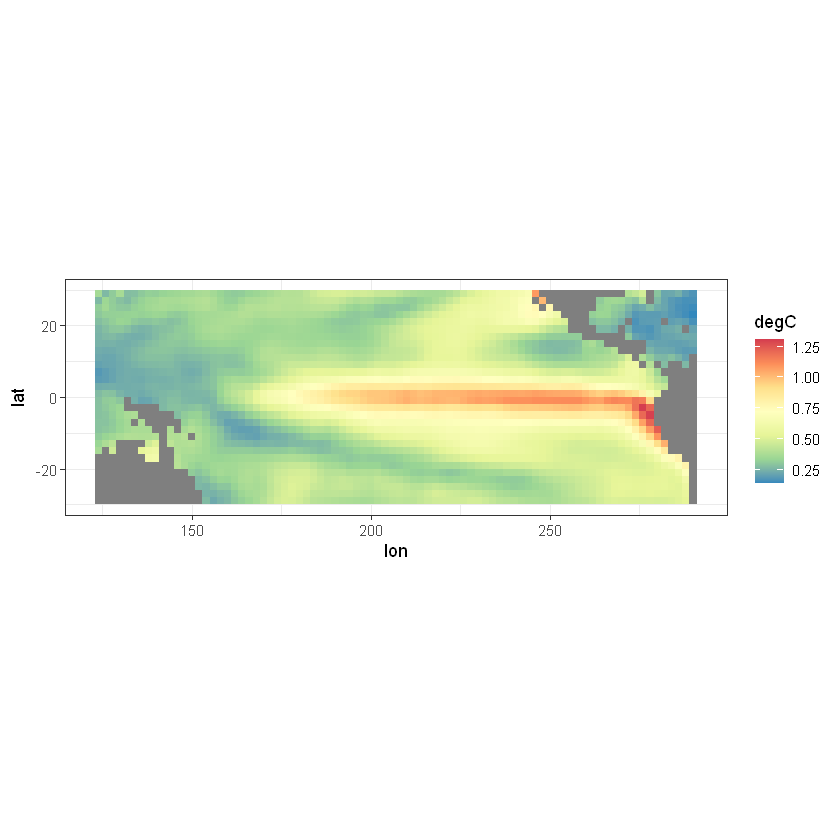

In [17]:
g1
g2
g3
g4
g5

In [18]:
data("DSTM_EM_results", package = "STRbook")

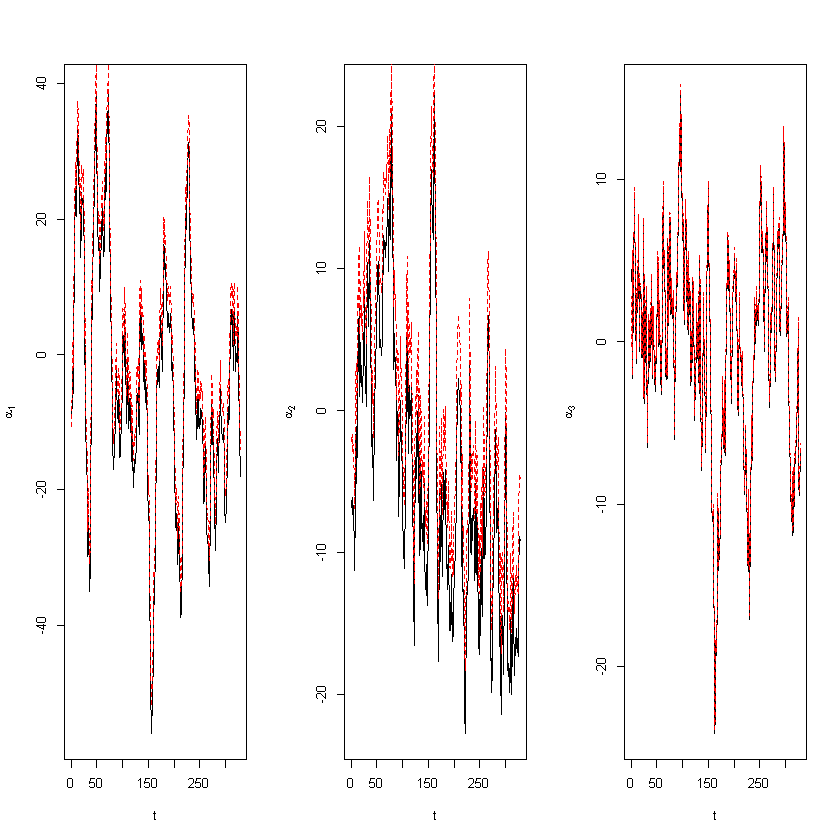

In [19]:
par(mfrow = c(1,3))
for(i in 1:3) {
  plot(DSTM_Results$alpha_smooth[i, ], type = 'l',
       xlab = "t", ylab = bquote(alpha[.(i)]))
  lines(TS[, i], lty = 'dashed', col = 'red')
}
par(mfrow = c(1,3))
for(i in 1:3) {
  plot(DSTM_Results$alpha_smooth[i,], type = 'l',
       xlab = "t", ylab = bquote(alpha[.(i)]))
  lines(TS[,i], lty = 'dashed', col = 'red')
}

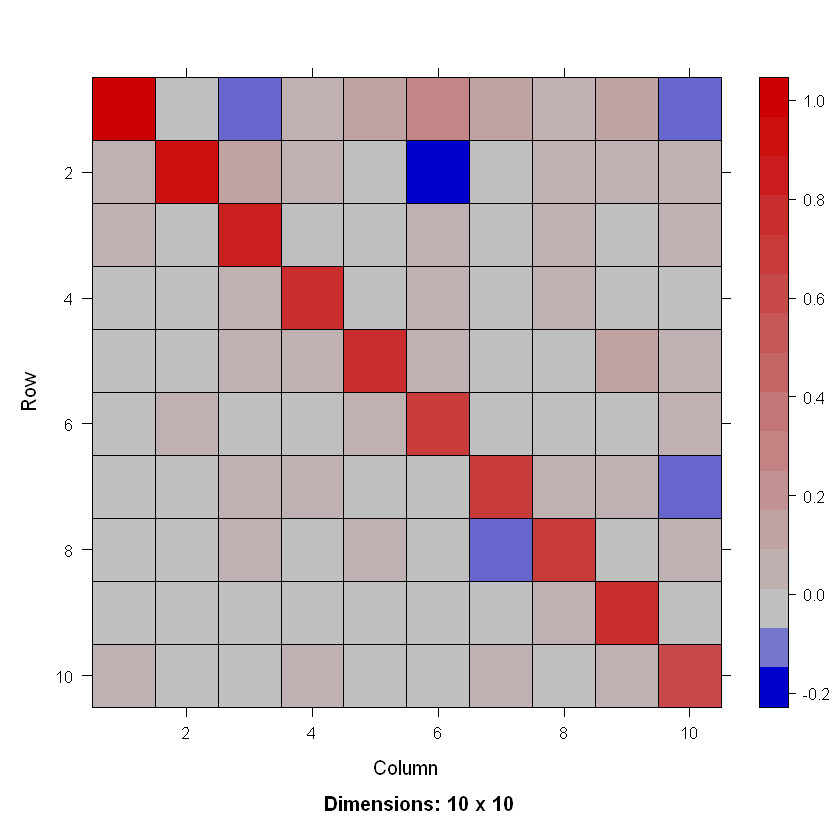

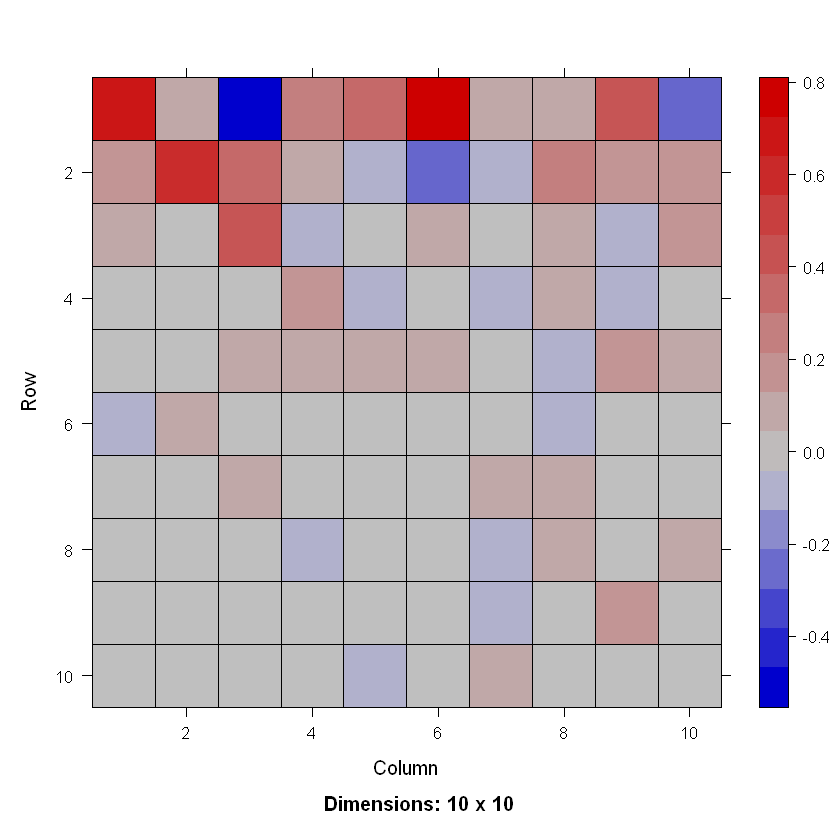

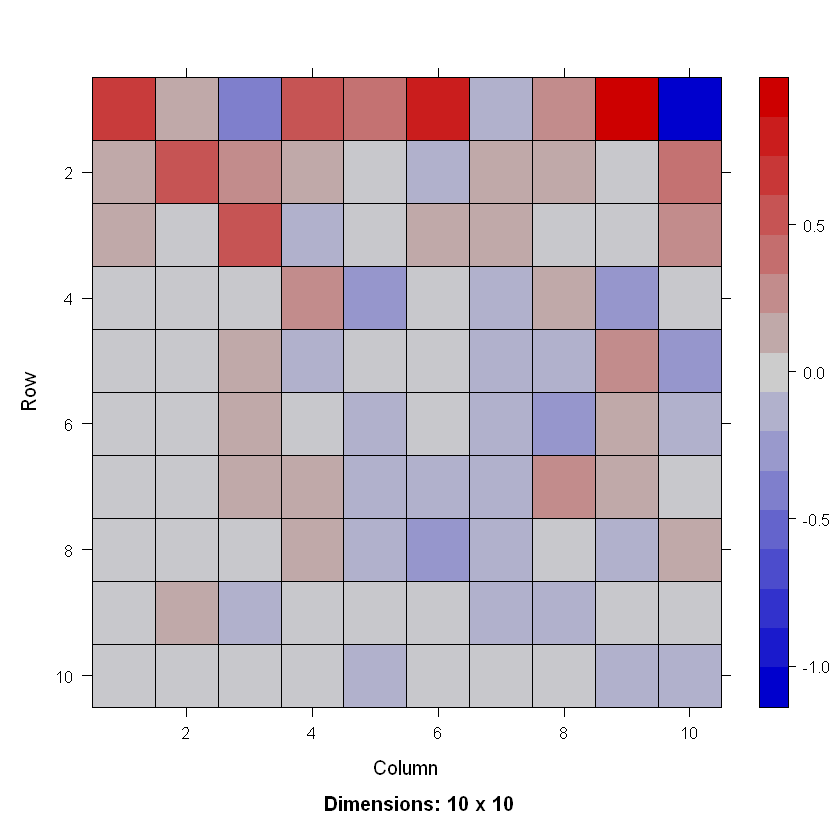

In [20]:
image(as(DSTM_Results$Mest, "Matrix"))
image(as(DSTM_Results$Mest %^% 6, "Matrix"))
image(as(Mest, "Matrix"))


In [21]:
alpha <- DSTM_Results$alpha_smooth[, nT]
P <- DSTM_Results$Cov0
for(t in 1:6) {
   alpha <- DSTM_Results$Mest %*% alpha
   P <- DSTM_Results$Mest %*% P %*% t(DSTM_Results$Mest) +
       DSTM_Results$Ceta
}